In [1]:
import cv2                                
import numpy as np                        
import pyrealsense2 as rs                
from detectron2_inference import *
import matplotlib.pyplot as plt 
print("Environment Ready")

Environment Ready


In [2]:
# Load model for detection
cuc=detectroninference("/media/asad/ADAS_CV/cuc/output_axels2/model_final.pth")

In [10]:
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 12]

In [92]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

Wd = 1024
Hd = 768
Wc = 1280
Hc = 720

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

config.enable_stream(rs.stream.depth, Wd, Hd, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, Wc, Hc, rs.format.bgr8, 30)
    print(f"Using LiDAR camera configuration")
else:
    config.enable_stream(rs.stream.color, W, H, rs.format.bgr8, 30)

# Start streaming
profile=pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
#motion_range = depth_sensor.get_option(rs.option.motion_range)
print(f"Depth Sensor units in m are {depth_sensor.get_option(rs.option.depth_units)}")
#val = 0
#depth_sensor.set_option(rs.option.motion_range, val)
aligned_stream = rs.align(rs.stream.color) # alignment between color and depth
point_cloud = rs.pointcloud()

Using LiDAR camera configuration
Depth Sensor units in m are 0.0002500000118743628


## Find inital depth put somewhere in initailization

In [93]:
## Initial Depth capture need to do it only once
while True:
        # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    frames = aligned_stream.process(frames)
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    points = point_cloud.calculate(depth_frame)
    if not depth_frame or not color_frame:
        continue
    else:
        pipeline.stop()
        print("Frames Captured")
        break     

Frames Captured


# Get intrinsics matrix of the sensors

In [94]:
#print(dir(aligned_stream))
pf = profile.get_stream(rs.stream.color) # Fetch stream profile for depth stream
intr = pf.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
print(intr)

[ 1280x720  p[653.111 350.482]  f[903.071 903.554]  Brown Conrady [0.17336 -0.527532 -0.000190233 0.000150312 0.484148] ]


## Get intial depth of the surface by taking median over window make sure the window is empty and does not have any uneven surface

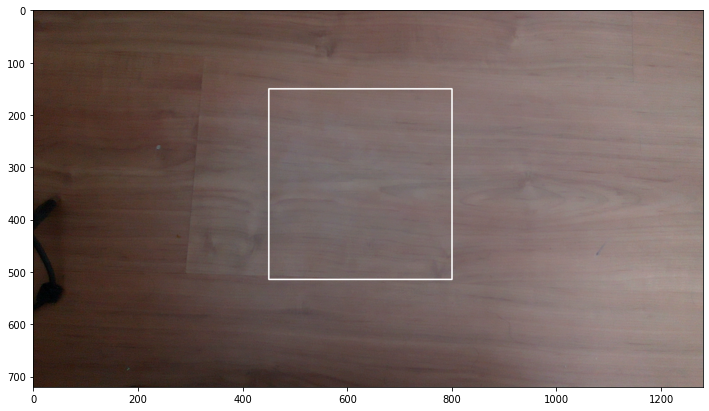

In [95]:
color_img = np.asanyarray(color_frame.get_data())[:,:,::-1]
vis=color_img.copy()
bbox = (int(450), int(150), int(700-350), int(514-150))
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(vis, p1, p2, (255, 255, 255), 2)
plt.imshow(vis)
H,W,C=color_img.shape

In [96]:
verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, W, 3)
obj_points = verts[int(bbox[1]):int(bbox[1] + bbox[3]), int(bbox[0]):int(bbox[0] + bbox[2])].reshape(-1, 3)
zs = obj_points[:, 2]
initial_depth=np.median(zs)
print(f"The initial depth is {initial_depth*100}cm")

The initial depth is 43.17500293254852cm


In [ ]:
#Testing projection
#obj_points = verts[int(bbox[1]), int(bbox[0])].reshape(-1,3)
#world_points=list(obj_points[0])
#out=rs.rs2_project_point_to_pixel(intr,world_points)
#cv2.circle(vis, (int(out[0]),int(out[1])), 5, (255, 255, 255), -1)
#plt.imshow(vis)

## Capture the frame for actual fruit

In [210]:
# Start streaming
profile=pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
aligned_stream = rs.align(rs.stream.color) # alignment between color and depth
point_cloud = rs.pointcloud()

while True:
        # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    frames = aligned_stream.process(frames)
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    points = point_cloud.calculate(depth_frame)
    if not depth_frame or not color_frame:
        continue
    else:
        pipeline.stop()
        print("Frames Captured")
        break        

Frames Captured


In [211]:
color_img = np.asanyarray(color_frame.get_data())
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
print(f"{color_img.shape}")
print(f"{colorized_depth.shape}")

(720, 1280, 3)
(720, 1280, 3)


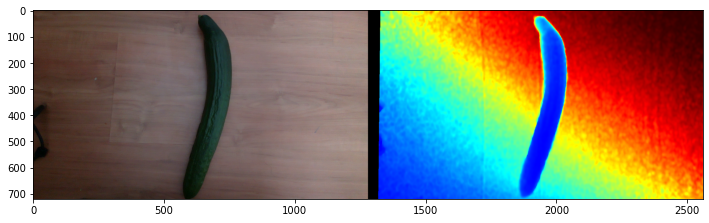

In [212]:
images = np.hstack((color_img[:,:,::-1], colorized_depth))
plt.imshow(images)

(720, 1280, 3)


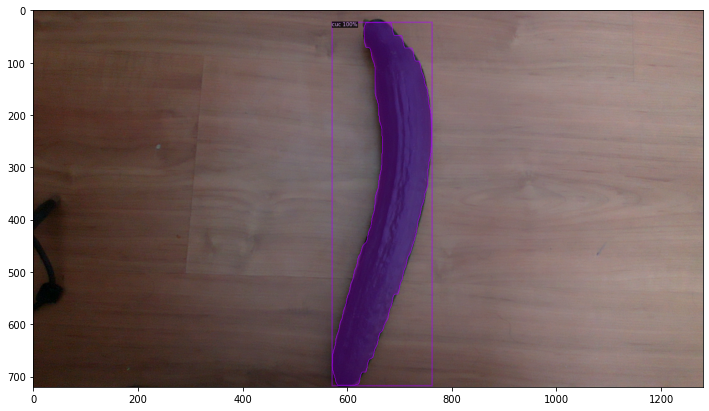

In [213]:
#img=cv2.imread("/media/asad/ADAS_CV/cuc/test_images2/test.jpg")
img=color_img
#print(img)
if img is not None:
    detected_cucumber,all_masks,all_patches,boxes,*_=cuc.pred(img)
else: 
    raise Exception("No image loaded")
print(detected_cucumber.shape)
plt.imshow(detected_cucumber[:,:,::-1])

## Get points of length Width and Height, Length is max y - min y over a window, Width is lower bound - upper bound at center over a window and depth is median height over mask        - inital height of surface, change it accordingly

In [214]:
def draw_circles(img,point):
    cv2.circle(img,point,1,(0,0,255),2)

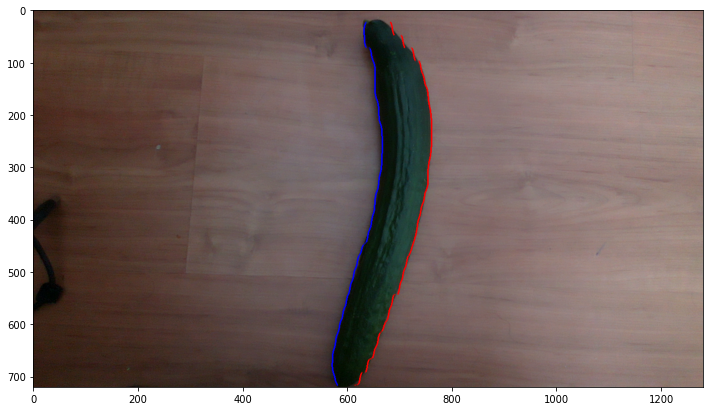

In [226]:
assert len(all_masks)==1, "More than one cucumber detected"
vis_img=img.copy()

for ind,mask in enumerate(all_masks):
    imgray=mask
    ys_mask,xs_mask=np.nonzero(mask)
    data=left_right_bound(imgray)
    lower_bound=[point[0] for point in data["data"]]
    upper_bound=[point[1] for point in data["data"]]
    draw_bounds(vis_img,lower_bound)
    draw_bounds(vis_img,upper_bound,(0,0,255))
    box=boxes[ind]
#Debug masks
#for i in range(xs_mask.shape[0]):
#    draw_circles(vis_img,(xs_mask[i],ys_mask[i]))
plt.imshow(vis_img[:,:,::-1])

In [227]:
xs_lb=[x for x,y in lower_bound]
ys_lb=[y for x,y in lower_bound]
xs_ub=[x for x,y in upper_bound]
ys_ub=[y for x,y in upper_bound]

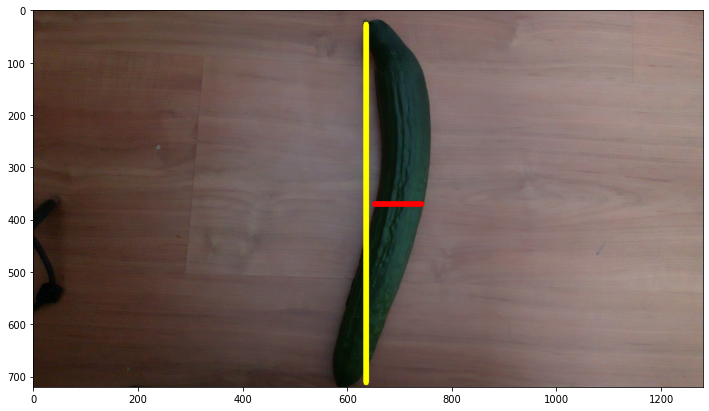

In [228]:
assert len(xs_lb)>100, "Too little points"
assert len(ys_lb)>100, "Too little points"
window=10
# length
length_start=ys_lb[0:window]
length_end=ys_lb[-window:]


#width at mid point
width_start=xs_lb[len(xs_lb)//2:len(xs_lb)//2+window]
width_end=xs_ub[len(xs_ub)//2:len(xs_ub)//2+window]
#print(len(width_start))
assert len(width_start)==len(width_end)==len(length_end)==len(length_end), "The lengths are not equal to window"

# For vis take median of windows
vis_img_dim=img.copy()
length_start_med=np.median(length_start)
length_end_med=np.median(length_end)
width_start_med=np.median(width_start)
width_end_med=np.median(width_end)
#print(length_start_med)
#print(length_end_med)
# Vis the width and length
vis_img_dim=cv2.line(vis_img_dim,(xs_lb[0],int(length_start_med)),(xs_lb[0],int(length_end_med)),(0, 255, 255),10)
cv2.line(vis_img_dim,(int(width_start_med),ys_lb[len(ys_lb)//2]),(int(width_end_med),ys_lb[len(ys_lb)//2]),(0, 0, 255),10)
plt.imshow(vis_img_dim[:,:,::-1])

## Visualization of 3D box

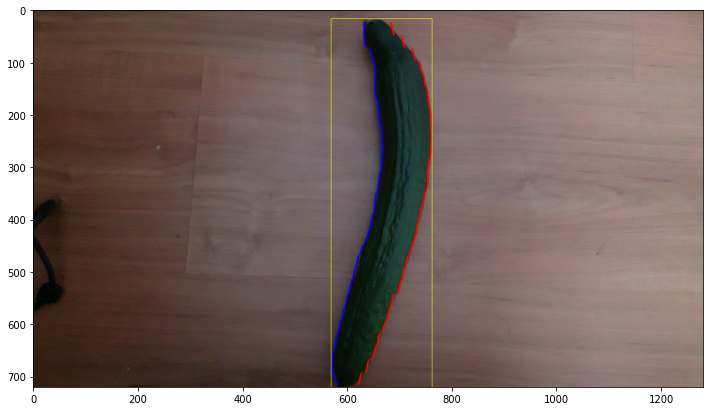

In [229]:
verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, W, 3)
obj_points_cuc_rt = verts[int(box[1]), int(box[0])].reshape(-1,3)
obj_points_cuc_bl = verts[int(box[3]), int(box[2])].reshape(-1,3)
world_points_rt=list(obj_points_cuc_rt[0])
world_points_bl=list(obj_points_cuc_bl[0])
img_rt=rs.rs2_project_point_to_pixel(intr,world_points_rt)
img_bl=rs.rs2_project_point_to_pixel(intr,world_points_bl)
cv2.rectangle(vis_img, (int(img_rt[0]),int(img_rt[1])), (int(img_bl[0]),int(img_bl[1])), (0, 255, 255), 1)
# Uncomment for debug
plt.imshow(vis_img[:,:,::-1])

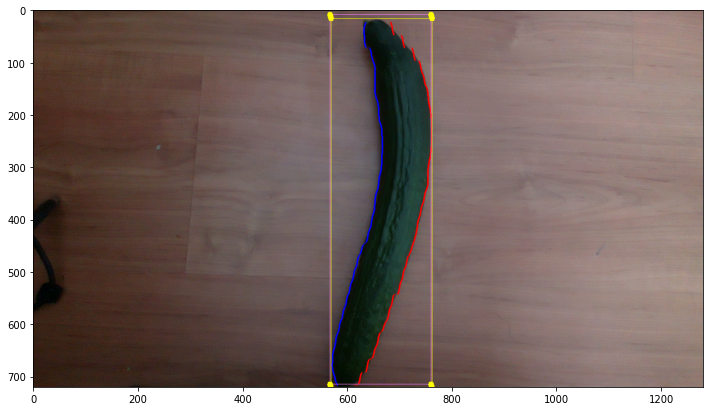

In [230]:
world_points_rt_bottom=world_points_rt
world_points_rt_bottom[2]=initial_depth
world_points_bl_bottom=world_points_bl
world_points_bl_bottom[2]=initial_depth
img_rt_bottom=rs.rs2_project_point_to_pixel(intr,world_points_rt_bottom)
img_bl_bottom=rs.rs2_project_point_to_pixel(intr,world_points_bl_bottom)
cv2.rectangle(vis_img, (int(img_rt_bottom[0]),int(img_rt_bottom[1])), (int(img_bl_bottom[0]),int(img_bl_bottom[1])), (255, 125, 255), 1)
## draw lines to make a cube only for vis
cv2.line(vis_img,(int(img_rt[0]),int(img_rt[1])),(int(img_rt_bottom[0]),int(img_rt_bottom[1])),(0,255,255),10)
cv2.line(vis_img,(int(img_bl[0]),int(img_rt[1])),(int(img_bl_bottom[0]),int(img_rt_bottom[1])),(0,255,255),10)
cv2.line(vis_img,(int(img_rt[0]),int(img_bl[1])),(int(img_rt_bottom[0]),int(img_bl_bottom[1])),(0,255,255),10)
cv2.line(vis_img,(int(img_bl[0]),int(img_bl[1])),(int(img_bl_bottom[0]),int(img_bl_bottom[1])),(0,255,255),10)
plt.imshow(vis_img[:,:,::-1])

## Calculate Fruits Dimennsions

In [231]:
length_start_pts=verts[length_start,xs_lb[0]].reshape(-1, 3)
length_end_pts=verts[length_end,xs_lb[0]].reshape(-1, 3)
ys = length_start_pts[:, 1]
ye = length_end_pts[:, 1]
ys=np.median(ys)
ye=np.median(ye)
length=np.abs(ye-ys)*100
print(f"The length is {length}")

The length is 32.28543400764465


In [232]:
width_start_pts=verts[ys_lb[len(ys_lb)//2],width_start].reshape(-1, 3)
width_end_pts=verts[ys_lb[len(ys_lb)//2],width_end].reshape(-1, 3)
xs = width_start_pts[:, 0]
xe = width_end_pts[:, 0]
xs=np.median(xs)
xe=np.median(xe)
width=np.abs(xs-xe)*100
print(f"The width is {width}")

The width is 4.113307595252991


In [233]:
obj_points = verts[ys_mask,xs_mask].reshape(-1, 3)
zs = obj_points[:, 2]
zm=np.median(zs)
print(zm)
height=np.abs(zm-initial_depth)*100
print(f"The depth is {height}")

0.40775
The depth is 2.400001883506775


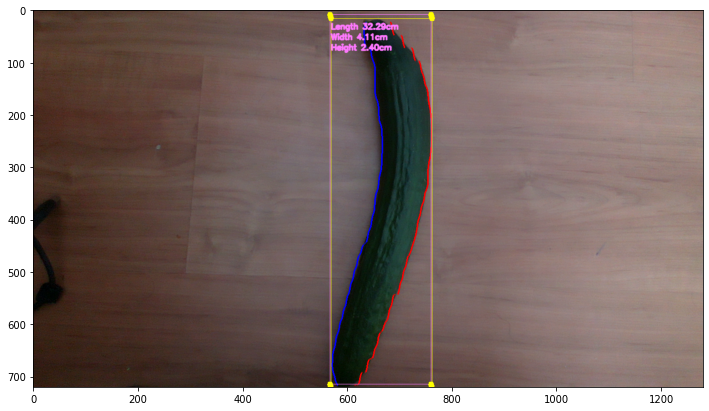

In [234]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (255, 120, 255)
thickness = 2
# Using cv2.putText() method
cv2.putText(vis_img, str(f"Length {length:.2f}cm"), (int(img_rt[0]),int(img_rt[1]+20)), font, fontScale, color, thickness, cv2.LINE_AA)
cv2.putText(vis_img, str(f"Width {width:.2f}cm"), (int(img_rt[0]),int(img_rt[1]+40)), font, fontScale, color, thickness, cv2.LINE_AA)
cv2.putText(vis_img, str(f"Height {height:.2f}cm"), (int(img_rt[0]),int(img_rt[1]+60)), font, fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(vis_img[:,:,::-1])

In [169]:

#ys = np.delete(ys, np.where((zs < z - 0.01) | (zs > z + 0.01)))  # take only y for close z to prevent including background